# Business Understanding

The Seattle Airbnb Dataset (including listings.csv, calendar.csv, reviews.csv) list up AirBnB accommodations in Seattle, their availability and Airbnb users' reviews. Paying attention on this dataset, I set the following problems to be addressed in this notebook and presented on blogspot:

### Some insights about Price Seasonality and Usage trend:

1. Highlighting seasonal patterns in pricing fluctuation and accommodation usage trends.
2. Which neighborhoods experience the highest and lowest prices throughout the years.
3. The way neighborhoods' attribute of property has impact on prices, with focus on features including the most expensive neighborhoods and the most common property types.

### Price Prediction
4. Can we develop a model to predict the price of giving current list of accommodations & reviews?
5. Which listing factors show the strongest correlation with price?


# Data Understanding

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from collections import Counter
%matplotlib inline

In [2]:
# Use for google colab only to mount file from gg drive, will comment it when submit
# Initialize default mount status variable == 0 mean not using google colab
ggdr_mnt = 0

'''
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    ggdr_mnt = 1  # Update the variable on successful mount
except Exception as e:
    print(f"An error occurred while mounting Google Drive: {e}")

print(f"ggdr_mnt = {ggdr_mnt}")  # Output the variable status
'''

if ggdr_mnt == 1:
    file_path = '/content/drive/My Drive/Colab Notebooks/Udacity-DS-Prj-1/Seattle/'
else:
    file_path = './Seattle/'

# Define the file path and the list of required files

required_files = ['listings.csv', 'calendar.csv', 'reviews.csv']

# Check if all required files exist
missing_files = [f for f in required_files if not os.path.isfile(os.path.join(file_path, f))]

if missing_files:
    print(f"Missing files: {missing_files}. Unzipping Seattle.zip...")
    # Execute the shell command to unzip the file
    !unzip -q "{file_path}Seattle.zip" -d "{file_path}"
else:
    print("All required files are already present. Skipping unzip operation.")

# capture output
from IPython.utils.capture import capture_output

with capture_output() as output:
    !ls "{file_path}"

# Print the captured output
print(output.stdout)

# import data, try catch error for first file listings.csv

try:
    listings_df = pd.read_csv(file_path + 'listings.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file 'listings.csv' was not found at path: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

calendar = pd.read_csv(file_path + 'calendar.csv')
reviews_df = pd.read_csv(file_path + 'calendar.csv')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
ggdr_mnt = 1
All required files are already present. Skipping unzip operation.
calendar.csv  listings.csv  reviews.csv  Seattle.zip

Data loaded successfully!


In [3]:
# Show top 5 records of listings
listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
# show top 5 records of calendar dataset
calendar.head(5)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
# show top 5 records of reviews
reviews_df.head(5)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


### Exploring datasets detail:

#### Calendar Dataset:
1. Showing number of col, row of the calendar dataset
2. Showing columns have missing data

In [6]:
# Check calendar df
print(calendar.isnull().sum())
print(calendar.describe(include='all'))

listing_id         0
date               0
available          0
price         459028
dtype: int64
          listing_id        date available    price
count   1.393570e+06     1393570   1393570   934542
unique           NaN         365         2      669
top              NaN  2016-01-04         t  $150.00
freq             NaN        3818    934542    36646
mean    5.550111e+06         NaN       NaN      NaN
std     2.962274e+06         NaN       NaN      NaN
min     3.335000e+03         NaN       NaN      NaN
25%     3.258213e+06         NaN       NaN      NaN
50%     6.118244e+06         NaN       NaN      NaN
75%     8.035212e+06         NaN       NaN      NaN
max     1.034016e+07         NaN       NaN      NaN


##### Conclusion: The price column is the only one with missing values.

#### Listings Dataset

1. Showing number of col and row
2. Showing number and name of columns have missing data
3. Showing other detail of categorical variables

In [7]:
# Showing number of col and row, columns have missing data
print(listings_df.shape)
print(listings_df.isnull().sum())

(3818, 92)
id                                    0
listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   627
Length: 92, dtype: int64


In [8]:
# Showing columns have missing data
print(listings_df.columns[listings_df.isnull().any()==True])
print(len(listings_df.columns[listings_df.isnull().any()==True]))

Index(['summary', 'space', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'zipcode', 'property_type', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'reviews_per_month'],
      dtype='object')
46


In [9]:
# Describe listing dataset
print(listings_df.describe(include='all'))

                  id                          listing_url     scrape_id  \
count   3.818000e+03                                 3818  3.818000e+03   
unique           NaN                                 3818           NaN   
top              NaN  https://www.airbnb.com/rooms/241032           NaN   
freq             NaN                                    1           NaN   
mean    5.550111e+06                                  NaN  2.016010e+13   
std     2.962660e+06                                  NaN  0.000000e+00   
min     3.335000e+03                                  NaN  2.016010e+13   
25%     3.258256e+06                                  NaN  2.016010e+13   
50%     6.118244e+06                                  NaN  2.016010e+13   
75%     8.035127e+06                                  NaN  2.016010e+13   
max     1.034016e+07                                  NaN  2.016010e+13   

       last_scraped                    name  \
count          3818                    3818   
uniqu

##### Conclusion: experiences_offered column contains "None" for all rows and jurisdiction_names column contains "WASHINGTON"

<ipython-input-10-0ad8f0146f50>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{int(x)}%' for x in plt.gca().get_xticks()])  # Format x-ticks as percentages


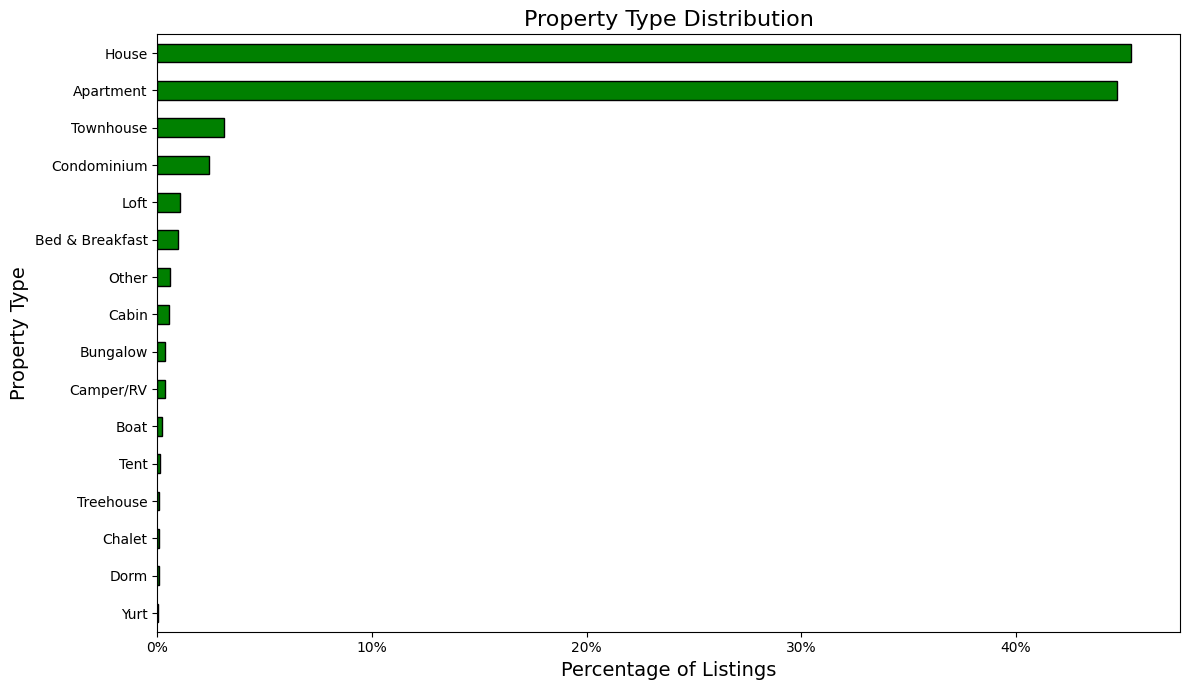

In [10]:
# Calculate the counts and percentages for each property type
property_counts = listings_df['property_type'].value_counts().sort_values(ascending=True)
property_percentages = property_counts / listings_df.shape[0] * 100

# Create the horizontal bar plot
plt.figure(figsize=(12, 7))  # Set the figure size
property_percentages.plot(kind="barh", color='green', edgecolor='black')  # Change to barh for horizontal bars

# Add a title and axis labels
plt.title("Property Type Distribution", fontsize=16)
plt.xlabel("Percentage of Listings", fontsize=14)  # Change x-label to reflect horizontal orientation
plt.ylabel("Property Type", fontsize=14)  # Change y-label to reflect horizontal orientation

# Format the x-axis to show percentage
plt.xticks(rotation=0)  # Ensure x-ticks are horizontal
plt.gca().set_xticklabels([f'{int(x)}%' for x in plt.gca().get_xticks()])  # Format x-ticks as percentages

# Display the plot
plt.tight_layout()
plt.show()


#### Review Dataset

1. Showing number of col, row of the dataset
2. showing number and name of columns having missing data
3. Showing other detail of categorical variables

In [11]:
# Showing number of col, row of the dataset and number of missing data columns
print(reviews_df.shape)
print(reviews_df.isnull().sum())

(1393570, 4)
listing_id         0
date               0
available          0
price         459028
dtype: int64


In [12]:
# Describe dataaset
print(reviews_df.describe(include='all'))

          listing_id        date available    price
count   1.393570e+06     1393570   1393570   934542
unique           NaN         365         2      669
top              NaN  2016-01-04         t  $150.00
freq             NaN        3818    934542    36646
mean    5.550111e+06         NaN       NaN      NaN
std     2.962274e+06         NaN       NaN      NaN
min     3.335000e+03         NaN       NaN      NaN
25%     3.258213e+06         NaN       NaN      NaN
50%     6.118244e+06         NaN       NaN      NaN
75%     8.035212e+06         NaN       NaN      NaN
max     1.034016e+07         NaN       NaN      NaN


# Data Preparation

### Understandings of Price Seasonal and Usage trend:

1. Identifying the seasonal trends in pricing and accommodation usage patterns?
2. In which neighborhoods do prices peak and hit their lowest points throughout the year?
3. How do property types within neighborhoods affect prices, particularly in the priciest neighborhoods and for the most common property types?

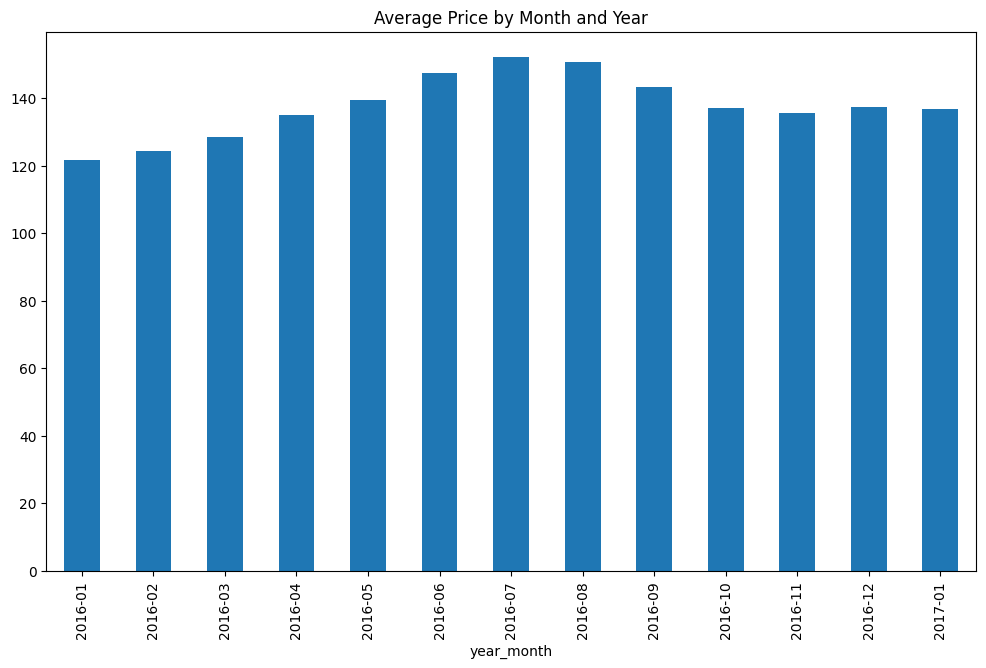

In [13]:
# Visualize Average Price by Month and Year
# Extracting year and month from the date column
calendar['year_month'] = pd.to_datetime(calendar['date']).dt.year.astype(str) + '-' + pd.to_datetime(calendar['date']).dt.month.astype(str)
calendar['year_month'] = pd.to_datetime(calendar['year_month'], format='%Y-%m').dt.to_period('M')

# Cleaning and converting the price column to a numeric format

calendar['price'] = calendar['price'].str.replace('[\$,]', '', regex=True).astype(float)


# Calculating the average price by year and month, then plotting
average_price = calendar.groupby(['year_month'])['price'].mean().sort_index(ascending=True)

average_price.plot(kind="bar", figsize=(12, 7), title="Average Price by Month and Year");


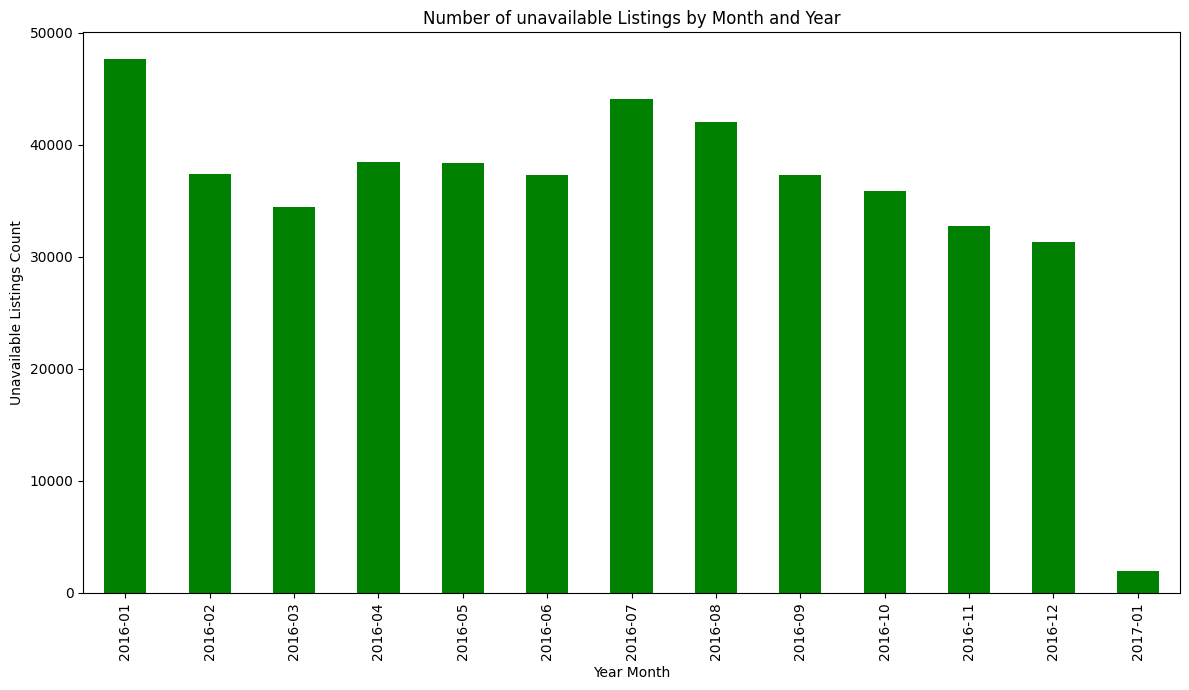

In [14]:
# Visualize Unavailable Listings count throughout the year
# Filter data for unavailable listings
useddate_df = calendar[calendar['available'] == "f"]

# Group by year and month to count unavailable listings and plot
useddate_df.groupby(['year_month'])['available'].count().plot(
    kind="bar",
    figsize=(12, 7),
    title="Number of unavailable Listings by Month and Year",
    color="green",
    legend=False
);

# Adding axis labels
plt.xlabel("Year Month")
plt.ylabel("Unavailable Listings Count")
plt.tight_layout()


##### Conlusion:

The price exhibited an noticeable seasonality trend throughout the year, with peaks in summer months (June, July, and August), reaching its highest point in July.
In contrast, the demand for booking accommodations fluctuated over the year, with January recording the highest number of bookings, followed by July and August, and drop to lowest level on Dec.


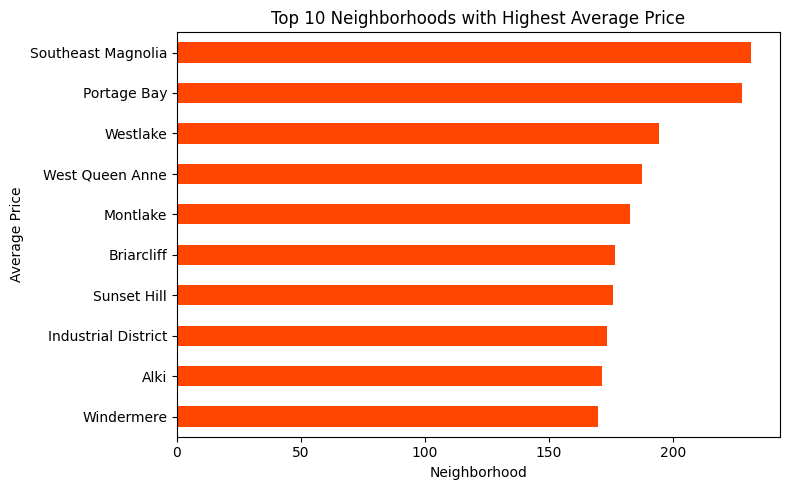

In [15]:
# Showing 5 neighborhood with Highest average price
# Removing the $ sign and converting the price column to float
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Grouping by neighborhood and calculating the average price
top10_highest = (
    listings_df.groupby('neighbourhood_cleansed')['price']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Plotting the top 10 neighborhoods with the highest average price
top10_highest.sort_values(ascending=True).plot(
    kind='barh',
    figsize=(8, 5),
    color='orangered',
    title='Top 10 Neighborhoods with Highest Average Price'
);

# Adding labels for clarity
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.tight_layout()

# Display the plot
plt.show()


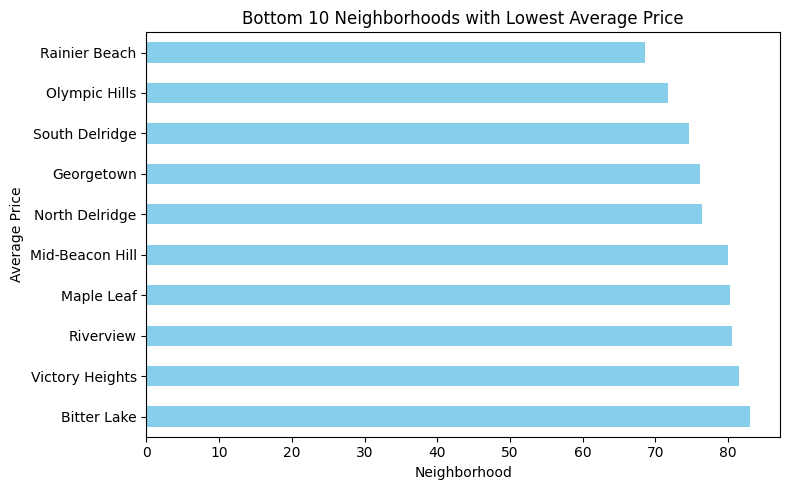

In [16]:
# Showing 10 neighborhood with lowest average price
# Grouping by neighborhood and calculating the average price
bottom10_low = (
    listings_df.groupby('neighbourhood_cleansed')['price']
    .mean()
    .sort_values(ascending=True)  # Sorting in ascending order for clarity
    .head(10)  # Fetching the bottom 10
)

# Plotting the bottom 10 neighborhoods with the lowest average price
bottom10_low.sort_values(ascending=False).plot(
    kind='barh',
    figsize=(8, 5),
    color='skyblue',
    title='Bottom 10 Neighborhoods with Lowest Average Price'
);

# Adding labels for clarity
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.tight_layout()

# Display the plot
plt.show()

##### Conlusion:
Scanning on neighborhood attribute, the list with the highest neighborhood average price was Southeast Magnolia, followed by Portage Bay, Westlake, West Queen Anne, and so on.

Meanwhiles, list with the lowest neighborhood average prices were Rainier Beach, followed by Olympic Hills, then by South Delridge, Georgetown, and so on.

In [17]:
# Explore property types within neighborhoods and how they impact price (focus on top 10 expensive neighborhoods and property types are house and apartment)

# Create tuples to filter listings based on the specified neighborhoods
# neighborhood = ('Southeast Magnolia', 'Portage Bay', 'Westlake', 'West Queen Anne', 'Montlake')
neighborhood = (top10_highest.index.to_list())
property = ('Apartment', 'House')

df_listings_1 = listings_df.loc[listings_df['neighbourhood_cleansed'].isin(neighborhood)]

# Further filter based on the property types
df_listings_2 = df_listings_1.loc[df_listings_1['property_type'].isin(property)]

# Grouping by neighborhood and property type to calculate the average price
df_prop = df_listings_2.groupby(['neighbourhood_cleansed', 'property_type'])[['price']].mean().reset_index()

# Display the result
df_prop


,neighbourhood_cleansed,property_type,price
0,Alki,Apartment,97.923077
1,Alki,House,210.125000
2,Briarcliff,Apartment,97.500000
3,Briarcliff,House,189.750000
4,Industrial District,Apartment,140.000000
5,Montlake,Apartment,133.333333
6,Montlake,House,191.533333
7,Portage Bay,Apartment,113.833333
8,Portage Bay,House,340.285714
9,Southeast Magnolia,Apartment,219.600000


In [18]:
# As there is no data for property type "House" for Industrial District, let's drop it so that the heatmap matrix will not get error of shaping
df_prop = df_prop[df_prop['neighbourhood_cleansed'] != 'Industrial District']
df_prop

,neighbourhood_cleansed,property_type,price
0,Alki,Apartment,97.923077
1,Alki,House,210.125000
2,Briarcliff,Apartment,97.500000
3,Briarcliff,House,189.750000
5,Montlake,Apartment,133.333333
6,Montlake,House,191.533333
7,Portage Bay,Apartment,113.833333
8,Portage Bay,House,340.285714
9,Southeast Magnolia,Apartment,219.600000
10,Southeast Magnolia,House,234.100000


In [19]:
price_list2 = df_prop['price'].values
price_list2 = np.reshape(price_list2, (9,2))
price_list2.shape
print(price_list2)

[[ 97.92307692 210.125     ]
 [ 97.5        189.75      ]
 [133.33333333 191.53333333]
 [113.83333333 340.28571429]
 [219.6        234.1       ]
 [ 85.         202.85714286]
 [128.20833333 247.39393939]
 [142.4        168.        ]
 [163.33333333 172.71428571]]


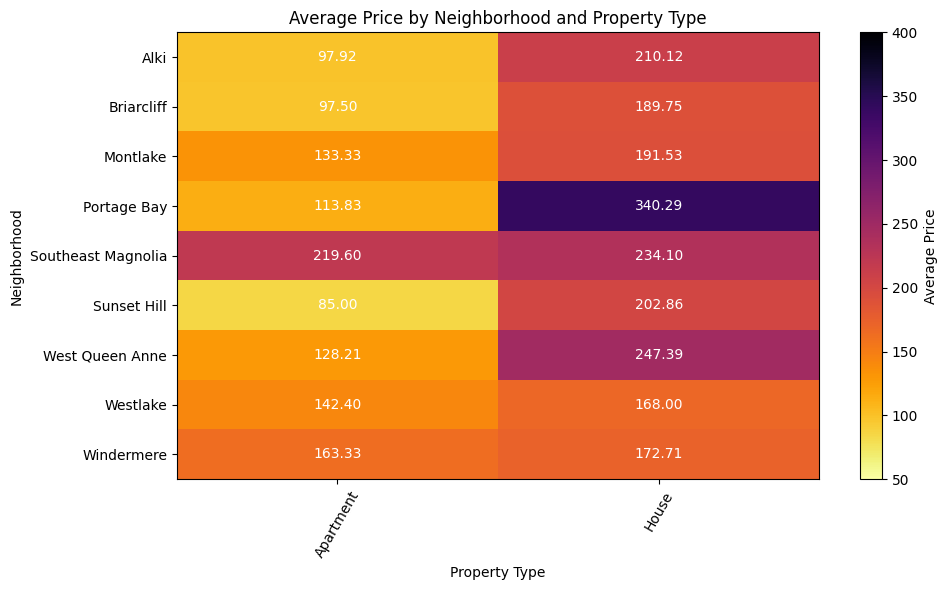

In [20]:
# Heatmap Creation
df_heatmap = df_prop.pivot(index='neighbourhood_cleansed', columns='property_type', values='price')

plt.figure(figsize=(10, 6))
plt.imshow(df_heatmap, cmap='inferno_r', aspect='auto', interpolation='nearest', vmin=50, vmax=400)

# Annotations
for i in range(len(df_heatmap.index)):
    for j in range(len(df_heatmap.columns)):
        plt.text(j, i, f'{df_heatmap.iloc[i, j]:.2f}', ha='center', va='center', color='white')

# Add labels and title
plt.title('Average Price by Neighborhood and Property Type')
plt.xlabel('Property Type')
plt.ylabel('Neighborhood')
plt.xticks(np.arange(len(df_heatmap.columns)), df_heatmap.columns, rotation=60)
plt.yticks(np.arange(len(df_heatmap.index)), df_heatmap.index)
plt.colorbar(label='Average Price')
plt.tight_layout()

# Display the heatmap

plt.show()


##### Conlusion:
- The focus is mainly on the highest-priced neighborhoods identified in the previous analysis, specifically concentrating on houses and apartments, as they represent a significant portion of the property types.

- The analysis indicates that Portage Bay has the most expensive houses, followed by West Queen Anne and Westlake. Additionally, in Westlake, both houses and apartments are priced similarly.

###  Price Prediction:
Can we develop a model to predict the price of giving current list of accommodations & reviews?

Which listing factors show the strongest correlation with price?

In [21]:
# check missing column:
listings_df['price'].isnull().sum()

0

In [22]:
# Create a copy of the original DataFrame
df_list_new = listings_df.copy()
# create list of columns to be dropped with small impact to price
cols_drop = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url',
    'license', 'xl_picture_url', 'host_id', 'host_url', 'host_thumbnail_url',
    'host_verifications', 'street', 'neighbourhood', 'neighbourhood_group_cleansed',
    'jurisdiction_names', 'host_picture_url', 'picture_url',
    'zipcode', 'smart_location', 'country', 'latitude', 'longitude', 'weekly_price',
    'monthly_price', 'calendar_updated', 'calendar_last_scraped', 'first_review',
    'last_review', 'calculated_host_listings_count', 'reviews_per_month'
]

# Drop the irrelevant columns
df_list_new = df_list_new.drop(cols_drop, axis=1)

print(df_list_new.columns)
print(df_list_new.shape)


Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'city', 'state',
       'market', 'country_code', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'square_feet', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_clean

In [23]:
# Review all the numerical columns and assess missing values
cols_numeric = df_list_new.select_dtypes(include=['float', 'int']).columns
for col in cols_numeric:
    print(col,df_list_new[col].isnull().sum())

host_listings_count 2
host_total_listings_count 2
accommodates 0
bathrooms 16
bedrooms 6
beds 1
square_feet 3721
price 0
guests_included 0
minimum_nights 0
maximum_nights 0
availability_30 0
availability_60 0
availability_90 0
availability_365 0
number_of_reviews 0
review_scores_rating 647
review_scores_accuracy 658
review_scores_cleanliness 653
review_scores_checkin 658
review_scores_communication 651
review_scores_location 655
review_scores_value 656


#### Findings & Fixing steps:

- Bathrooms: There are 16 records with missing values for bathrooms. Since this is a small percentage, we will set the missing values to 0.
- Bedrooms: For rows where the bedroom field is blank, since all have at least one bed, we will fill the missing values with 1.
- Beds: There is one record with a missing value for beds, but the bed type is specified as "Real Bed." We will set the value of beds to 1 for this record.
- Square Feet: Since most values in the square_feet column are missing, we will drop this column entirely.
- Review Scores: All review-related score columns with missing values will be set to 0, assuming these listings have no review scores.
- Host Listings Count: For the two rows with missing values in the host listings columns, we will fill these with 1, as these host IDs are associated with only one listing each.

In [24]:
# Fill NaN values in the bathrooms column with 0
df_list_new['bathrooms'] = df_list_new['bathrooms'].fillna(0)

# Fill NaN values in the bedrooms column with 1 (since all rows with blank bedroom field have at least 1 bed) and set beds missing record to 1
df_list_new['bedrooms'] = df_list_new['bedrooms'].fillna(1)
df_list_new['beds'] = df_list_new['beds'].fillna(1)

# Drop the square_feet column as most of its values are NaN
df_list_new = df_list_new.drop('square_feet',axis=1)
# Set all NaN values in review_scores columns to 0 (assuming no review scores for these listings)
cols_0 = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']

df_list_new[cols_0] = df_list_new[cols_0].fillna(0)

# fill host_listing_count == 1
df_list_new['host_listings_count'] = df_list_new['host_listings_count'].fillna(1)
df_list_new['host_total_listings_count'] = df_list_new['host_total_listings_count'].fillna(1)

In [25]:
# Review all the categorical columns and assess missing values

cols_cat = df_list_new.select_dtypes(include=['object']).columns
print(col,df_list_new[cols_cat].isnull().sum())

review_scores_value name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523
host_acceptance_rate                 773
host_is_superhost                      2
host_neighbourhood                   300
host_has_profile_pic                   2
host_identity_verified                 2
neighbourhood_cleansed                 0
city                                   0
state                                  0
market                                 0
country_code                         

In [26]:
# check value of each category columns
for i in cols_cat:
  print(f"{i}: {df_list_new[i].dtype} \n{df_list_new[i].unique()}")

name: object 
['Stylish Queen Anne Apartment' 'Bright & Airy Queen Anne Apartment'
 'New Modern House-Amazing water view' ...
 'Private apartment view of Lake WA' 'Amazing View with Modern Comfort!'
 'Large Lakefront Apartment']
summary: object 
[nan
 "Chemically sensitive? We've removed the irritants triggering allergy or asthma attacks, like carpeting, forced air & used pillows, all culprits that harbor fungus, mold & bacteria.  No smoking, no pets.  Designed for healthy living, so breathe easy."
 'New modern house built in 2013.  Spectacular sunset/water views and light, rooftop deck and lounge area, hot tub, 5 bedrooms, gourmet kitchen.  Perfect for 2-3 families, walk to downtown.  Located in highly desirable Queen Anne neighborhood.'
 ...
 'Very comfortable lower unit. Quiet, charming mid-century neighborhood with amazing views of Lake Washington. Easy access to Seatac airport, downtown or Bellevue.'
 'Cozy studio condo in the heart on Madison Park on Lake WA! Just steps away from

#### Findings & Fixing steps:

- Property Type: Drop records value na.

- Summary, Space, Neighborhood Overview, Notes, Transit: These are categorical fields describing the property -> converted into boolean fields.

- Host-related fields: host_name, host_since, host_location, host_about, host_picture_url, host_neighbourhood are categorical fields describing the host -> converted into boolean fields.

- Host Response and Acceptance Rate -> assign "N/A" where the value is missing (NaN).

- Host Response Rate: This should be a numerical field --> Convert host_response_rate to a float, and replace "N/A" or blanks with 0.

- Host Details: For host_is_superhost, host_has_profile_pic, and host_identity_verified, assign 1 for True (t), 0 for False (f), and replace missing values (NaN) with 0.

- Security Deposit and Cleaning Fee: Remove the $ signs, convert them to floats. If cleaning_fee is missing, assume the value is 0.

Fields to Clean:

- Convert name, description, and picture_url into boolean fields.
- Drop the experiences_offered column.
- Drop the market, country code and state column as they have only 1 value.
- Convert is_location_exact, has_availability, requires_license, instant_bookable, require_guest_profile_picture, and require_guest_phone_verification fields from t/f values to 1/0.
- Extra People: Remove the $ sign from extra_people and convert it to a float.

- City: Convert all city names in the city column to lowercase and remove extra spaces.

- The amenities field contains a list of values for each row and needs to be splitted or melted.


#### Change some of text fields to boolean

In [27]:
def boolean_change(data):
    '''
    This function converts columns into 1/0 (true/false): If data input is empty, NaN, or None, return 0. Otherwise, return 1.
    '''
    if pd.isna(data) or data == '':
        return 0
    else:
        return 1

# List of info columnss to convert
info_cols = ['summary', 'space', 'neighborhood_overview', 'notes', 'transit', 'name', 'description',
               'host_name', 'host_since', 'host_location', 'host_about', 'host_neighbourhood']

# Apply the boolean_change function to each specified field using a lambda function
for i in info_cols:
    df_list_new[i] = df_list_new[i].apply(lambda x: boolean_change(x)).astype('bool')

# Check type
print(df_list_new[info_cols].dtypes)

summary                  bool
space                    bool
neighborhood_overview    bool
notes                    bool
transit                  bool
name                     bool
description              bool
host_name                bool
host_since               bool
host_location            bool
host_about               bool
host_neighbourhood       bool
dtype: object


#### Convert all boolean fields (currently with value t/f) to 1/0

In [28]:
def boolean_change_tf(data):
    '''
    This function converts boolean columns into 1/0 based on their values: If the value is 't' (True), it returns 1; otherwise, it returns 0.
    '''
    if pd.isna(data):
        return 0
    elif data == 't':
        return 1
    else:
        return 0

# List of boolean columns to convert
bool_cols = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
    'is_location_exact', 'has_availability', 'requires_license',
    'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification'
]

# Apply the function to the specified fields
for i in bool_cols:
    df_list_new[i] = df_list_new[i].apply(boolean_change_tf).astype('bool')

# Check type
print(df_list_new[bool_cols].dtypes)


host_is_superhost                   bool
host_has_profile_pic                bool
host_identity_verified              bool
is_location_exact                   bool
has_availability                    bool
requires_license                    bool
instant_bookable                    bool
require_guest_profile_picture       bool
require_guest_phone_verification    bool
dtype: object


In [29]:
# Drop rows with missing values in the 'property_type' column
df_list_new = df_list_new.dropna(subset=['property_type'], axis=0)

# Assign N/A where values are missing
df_list_new['host_response_time'] = df_list_new['host_response_time'].fillna('N/A')
df_list_new['host_acceptance_rate'] = df_list_new['host_acceptance_rate'].fillna('N/A')

# For 'host_response_rate', replace 'N/A' with 0, remove percentage signs, and convert to float
df_list_new['host_response_rate'] = df_list_new['host_response_rate'].apply(lambda x: 0 if x == 'N/A' else x)
df_list_new['host_response_rate'] = df_list_new['host_response_rate'].replace(r'[\%,]', '', regex=True).astype(float)
df_list_new['host_response_rate'] = df_list_new['host_response_rate'].fillna(0)

# Remove $ sign and assign 0 to missing values in financial columns
amount_cols = ['security_deposit','cleaning_fee','extra_people']
for a in amount_cols:
  df_list_new[a] = df_list_new[a].replace(r'[\$,]', '', regex=True).astype(float)
  df_list_new[a] = df_list_new[a].fillna(0)


# Drop unnecessary columns with only 1 value
df_list_new = df_list_new.drop(['experiences_offered', 'market', 'country_code', 'state'], axis=1)

# Lowercase and trim spaces for city and state fields
df_list_new['city'] = df_list_new['city'].str.lower().str.strip()


<ipython-input-29-161a4d5844c1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list_new['host_response_time'] = df_list_new['host_response_time'].fillna('N/A')
<ipython-input-29-161a4d5844c1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list_new['host_acceptance_rate'] = df_list_new['host_acceptance_rate'].fillna('N/A')
<ipython-input-29-161a4d5844c1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [30]:
# Assuming df_list_new is already defined and contains the 'amenities' column
amenities = []

# Iterate through each row in the DataFrame
for index, row in df_list_new.iterrows():
    # Clean the amenities string
    cleaned_amenities = row['amenities'].replace('{', '').replace('}', '').replace('"', '')
    # Split the cleaned string into a list
    split_list = cleaned_amenities.split(',')
    # Extend the amenities list with the split items
    amenities.extend(split_list)

# Count the occurrences of each amenity
amenities_count = Counter(amenities)

# Get the most common amenities
most_common_amenities = amenities_count.most_common()

# Display the most common amenities
print(most_common_amenities)

[('Wireless Internet', 3666), ('Heating', 3626), ('Kitchen', 3422), ('Smoke Detector', 3280), ('Essentials', 3237), ('Dryer', 2996), ('Washer', 2991), ('Internet', 2811), ('Shampoo', 2670), ('TV', 2574), ('Carbon Monoxide Detector', 2485), ('Fire Extinguisher', 2196), ('Free Parking on Premises', 2166), ('Family/Kid Friendly', 1962), ('First Aid Kit', 1679), ('Cable TV', 1446), ('Indoor Fireplace', 885), ('Pets live on this property', 882), ('Hangers', 846), ('Elevator in Building', 785), ('Hair Dryer', 774), ('Laptop Friendly Workspace', 745), ('Iron', 742), ('Safety Card', 727), ('Air Conditioning', 677), ('24-Hour Check-in', 616), ('Buzzer/Wireless Intercom', 538), ('Dog(s)', 508), ('Pets Allowed', 472), ('Gym', 442), ('Cat(s)', 382), ('Hot Tub', 303), ('Wheelchair Accessible', 300), ('Breakfast', 291), ('Suitable for Events', 209), ('Pool', 159), ('Lock on Bedroom Door', 100), ('Doorman', 85), ('Smoking Allowed', 82), ('Other pet(s)', 50), ('', 45), ('Washer / Dryer', 2)]


In [31]:
# Rename Amenities for better description
# List of amenities with their corresponding descriptions
amenities_new = [
    'amenities_wireless_internet|Wireless Internet',
    'amenities_heating|Heating',
    'amenities_kitchen|Kitchen',
    'amenities_smoke_detector|Smoke Detector',
    'amenities_essentials|Essentials',
    'amenities_dryer|Dryer',
    'amenities_washer|Washer',
    'amenities_internet|Internet',
    'amenities_shampoo|Shampoo',
    'amenities_tv|TV',
    'amenities_carbon_monoxide_detector|Carbon Monoxide Detector',
    'amenities_fire_extinguisher|Fire Extinguisher',
    'amenities_free_parking|Free Parking'
]

# Iterate over each amenity and create a new column in the DataFrame
for c in amenities_new:
    c_col, c_desc = c.split('|')
    # Create a new column based on the presence of the amenity in the 'amenities' column
    df_list_new[c_col] = df_list_new['amenities'].apply(lambda x: 1 if c_desc in x else 0)


In [32]:
# Drop the original amenities column
df_list_new = df_list_new.drop('amenities', axis = 1)

# Dummies for categorical columns
fields_cat = df_list_new.select_dtypes(include=['object']).columns

df_list_new = pd.get_dummies(df_list_new, columns=fields_cat)
df_list_new.head()

,name,summary,space,description,neighborhood_overview,notes,transit,host_name,host_since,host_location,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,True,False,True,True,False,False,False,True,True,True,...,False,False,False,False,False,False,True,False,True,False
1,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,True,False,False,True
2,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,True,False,False,True
3,True,True,False,True,False,False,False,True,True,True,...,False,False,False,False,False,False,True,True,False,False
4,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,True,False,False,True


#### Modeling:

In [33]:
# Create list of Dependent variable Y as Price, Independent variables X
y = df_list_new['price']
X = df_list_new.drop(['price'], axis=1)

In [34]:
# Train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=44)


In [35]:
# Instantiate a StandardScaler for feature scaling
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate linear regression model
lm_model = LinearRegression()

# Fit the model to the scaled training data
lm_model.fit(X_train_scaled, y_train)

# Predict and score the model
y_train_preds = lm_model.predict(X_train_scaled)
y_test_preds = lm_model.predict(X_test_scaled)

# Compute R-squared, mean-squared error for training and testing data
train_r2_score = r2_score(y_train, y_train_preds)
test_r2_score = r2_score(y_test, y_test_preds)
train_mse_score = mean_squared_error(y_train, y_train_preds)
test_mse_score = mean_squared_error(y_test, y_test_preds)

print("The training data r-squared {}. The test data was {}.".format(train_r2_score, test_r2_score))
print("The training data mse {}. The test data was {}.".format(train_mse_score, test_mse_score))


The training data r-squared 0.6529499836598398. The test data was -4.784647248120514e+21.
The training data mse 2835.7684584921712. The test data was 3.8597792259093817e+25.


In [36]:
def coef_cal(lm_model, X_train):
    # Create a DataFrame to hold the coefficients and feature names
    df_coef = pd.DataFrame()
    df_coef['feature'] = X_train.columns  # Changed 'est_int' to 'feature' for clarity
    df_coef['coefs'] = lm_model.coef_  # Get the coefficients from the model
    df_coef['absolute_coefs'] = np.abs(lm_model.coef_)  # Calculate absolute values of coefficients

    # Sort the DataFrame by absolute coefficients in descending order
    df_coef = df_coef.sort_values('absolute_coefs', ascending=False)

    return df_coef

# Assuming lm_model is your fitted linear model and X_train is your training data
df_coef = coef_cal(lm_model, X_train)

# Display the top 10 coefficients
print(df_coef.head(10))

                             feature         coefs  absolute_coefs
65         host_acceptance_rate_100%  5.915096e+14    5.915096e+14
66          host_acceptance_rate_N/A  5.911232e+14    5.911232e+14
175        room_type_Entire home/apt  4.643168e+14    4.643168e+14
176           room_type_Private room  4.522033e+14    4.522033e+14
182                bed_type_Real Bed  3.744824e+14    3.744824e+14
180                   bed_type_Futon  2.644367e+14    2.644367e+14
156                     city_seattle -2.544999e+14    2.544999e+14
76   neighbourhood_cleansed_Broadway  2.310104e+14    2.310104e+14
14               host_listings_count  2.090722e+14    2.090722e+14
15         host_total_listings_count -2.090722e+14    2.090722e+14


#### Conlusion:

After modeling the data, both the training and test datasets has an R-squared value of 0.62. The coefficient analysis shows that the most positive influential factors on the price were a combination of host details and descriptive listing information, including fields such as host acceptance rate, room type (entire or private room) where negative factors example are city of Seattle.